In [2]:
%load_ext autoreload
%aimport tensor_toolbox
%autoreload 1

# 2. The mathematical building blocks of neural networks

## 2.1 A first look at a neural network

**Listing 2.1: Loading the MNIST dataset**

==================== train_images | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (60000, 28, 28) | nDims: 3 | dtype: uint8


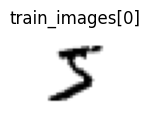


==================== train_labels | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (60000,) | nDims: 1 | dtype: uint8
Content: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
... (showing only the first 20 elements)

==================== test_images | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (10000, 28, 28) | nDims: 3 | dtype: uint8


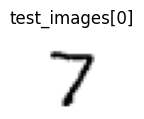


==================== test_labels | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (10000,) | nDims: 1 | dtype: uint8
Content: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
... (showing only the first 20 elements)



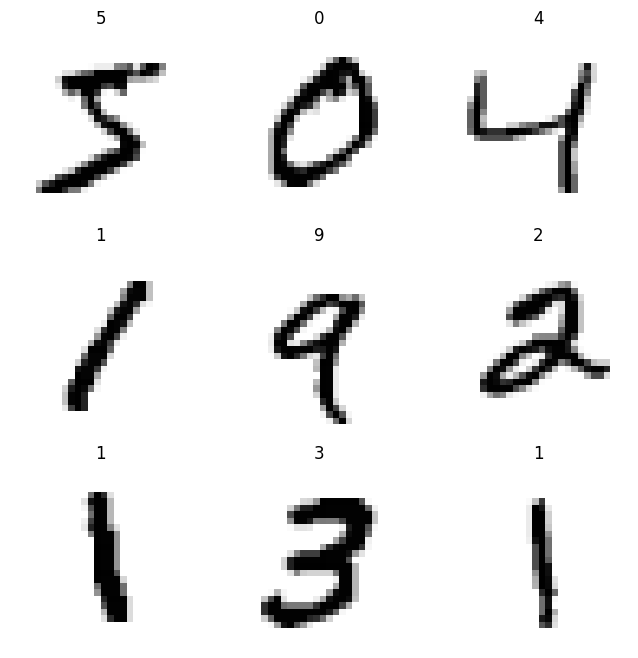

In [3]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# In Keras over TensorFlow, MNIST data gets loaded as numpy arrays.
tensor_toolbox.tensor_info(train_images, "train_images")
tensor_toolbox.tensor_info(train_labels, "train_labels")
tensor_toolbox.tensor_info(test_images, "test_images")
tensor_toolbox.tensor_info(test_labels, "test_labels")

# Draw first 9 images:
tensor_toolbox.draw_grid(train_images[:10], train_labels[:10])

==================== train_dataloader | tensor_info ====================
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 128
-- First batch of features
Type: <class 'torch.Tensor'>
Shape: torch.Size([128, 1, 28, 28]) | nDims: 4 | dtype: torch.float32


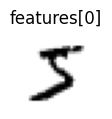


-- First batch of labels
Type: <class 'torch.Tensor'>
Shape: torch.Size([128]) | nDims: 1 | dtype: torch.int64
Content: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9])
... (showing only the first 20 elements)


==================== test_dataloader | tensor_info ====================
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 128
-- First batch of features
Type: <class 'torch.Tensor'>
Shape: torch.Size([128, 1, 28, 28]) | nDims: 4 | dtype: torch.float32


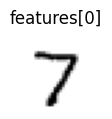


-- First batch of labels
Type: <class 'torch.Tensor'>
Shape: torch.Size([128]) | nDims: 1 | dtype: torch.int64
Content: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
... (showing only the first 20 elements)




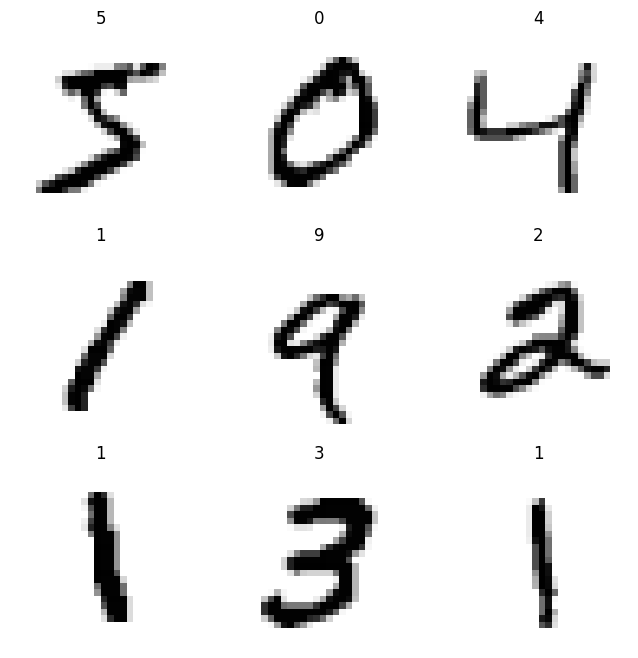

In [4]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.tensor_toolbox.data import DataLoader

# PyTorch has objects Dataset to hold the samples and labels, and DataLoader to iterate easily.
training_data = MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
# Dataloaders support automatic batching!
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_data = MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

tensor_toolbox.tensor_info(train_dataloader, "train_dataloader")
tensor_toolbox.tensor_info(test_dataloader, "test_dataloader")
# They are identical as both work in 128-sized batches.
# Dimension corresponds to [Samples, Color, Height, Width]

# Draw first nine images from first batch. I could iterate directly over the dataset, but didn't feel like it:
X, y = next(iter(train_dataloader))
tensor_toolbox.draw_grid(X[:10], [label.item() for label in y[:10]])

**Listing 2.2: The network architecture**

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
# Keras is very straightforward!
model = keras.Sequential([
    layers.Dense(512, activation="relu"), # 512 units, ReLU activation
    layers.Dense(10, activation="softmax") # 10 units, softmax activation (one-hot encoded label)
])

In [6]:
# Build the model and print the summary
model.build(input_shape=(1,28*28))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 512)                  401920    
                                                                 
 dense_1 (Dense)             (1, 10)                   5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from torch import nn
import torch.nn.functional as F
# In PyTorch, models inherit from nn.Module. We define the layers in the constructor and the forward
# prop in the function forward. More verbose but easier to customize.
class TorchModel(nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        self.flatten = nn.Flatten() # Transforms the 28x28 image into a 1D tensor
        self.stack = nn.Sequential(
            nn.Linear(28*28, 512), # 512 units
            nn.ReLU(), # ReLU activation
            nn.Linear(512, 10) # 10 units
        )
    
    def forward(self, x): # Forward prop
        x = self.flatten(x)
        output = self.stack(x)
        return F.log_softmax(output, dim=1) # Log-softmax activation

In [8]:
# Torchsummary prints very similar information to Keras summary()
torchmodel = TorchModel() # Instantiate the model

from torchsummary import summary
summary(torchmodel, input_size=(1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.55
Estimated Total Size (MB): 1.57
----------------------------------------------------------------


**Listing 2.3: The compilation step**

In [9]:
# Again, Keras is pretty straightforward here.
model.compile( # Compile the model with the optimizer, loss function and metrics
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
import torch.optim as optim
import torch.nn as nn

import torch # Import PyTorch

# Define RMSprop optimizer
optimizer = optim.RMSprop(torchmodel.parameters())

# Define loss function (CrossEntropyLoss for integer labels)
criterion = nn.CrossEntropyLoss()

def train(train_dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for X, y in train_dataloader: # Iterate over batches 
        # Compute prediction error
        y_hat = model(X)
        loss = loss_fn(y_hat, y)

        # Backpropagation
        optimizer.zero_grad() # Set gradients to zero
        loss.backward() # Compute gradient
        optimizer.step() # Update weights

        # Accumulate loss and calculate accuracy
        total_loss += loss.item()
        total_correct += (torch.argmax(y_hat, dim=1) == y).sum().item()
        total_samples += y.size(0)

    # Calculate overall average loss and accuracy
    avg_loss = total_loss / len(train_dataloader)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


**Listing 2.4: Preparing the image data**

==================== train_images | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (60000, 28, 28) | nDims: 3 | dtype: uint8


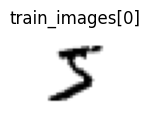


==================== train_images_reshaped | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (60000, 784) | nDims: 2 | dtype: float32
train_images_reshaped[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
... (showing only the first 20 elements)



In [10]:

# In tf, we used the numpy array operation reshape and divided by the scalar 255
# so that all values go between 0 and 1.
# The MNIST dataset loaded in PyTorch is already normalized, and it gets flattened
# in the input of the neural network.
tensor_toolbox.tensor_info(train_images, "train_images")
train_images_reshaped = train_images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images_reshaped = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
tensor_toolbox.tensor_info(train_images_reshaped*255, "train_images_reshaped", image=False)

**Listing 2.5: "Fitting" the model**

In [11]:
model.fit(train_images_reshaped, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2522 - accuracy: 0.9276
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1013 - accuracy: 0.9699
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0668 - accuracy: 0.9802
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0489 - accuracy: 0.9849
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0370 - accuracy: 0.9888


In [12]:
# Manually write the loop in PyTorch!
epochs = 5
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    avg_loss, accuracy = train(train_dataloader, torchmodel, criterion, optimizer)
    print(f"Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/5
Average Loss: 0.9796, Accuracy: 0.9185
Epoch 2/5
Average Loss: 0.1373, Accuracy: 0.9601
Epoch 3/5
Average Loss: 0.1014, Accuracy: 0.9706
Epoch 4/5
Average Loss: 0.0816, Accuracy: 0.9766
Epoch 5/5
Average Loss: 0.0733, Accuracy: 0.9792


**Listing 2.6: Using the model to make predictions**

In [13]:
test_image = test_images_reshaped[42].reshape((1, 28 * 28))
test_label = test_labels[42]

# Keras: predict() method returns the probabilities of each class.
keras_prediction = model.predict(test_image, verbose=0)
tensor_toolbox.tensor_info(keras_prediction, "Keras predictions")

#PyTorch: torch.softmax() returns the probabilities of each class.
test_images_tensor = torch.tensor(test_image) # Convert numpy array to PyTorch tensor
torchmodel.eval() # Set the model to evaluation mode
with torch.no_grad(): 
    logits = torchmodel(test_images_tensor) # Compute the logits without gradient tracking

torch_prediction = torch.softmax(logits, dim=1) 
tensor_toolbox.tensor_info(torch_prediction, "PyTorch predictions")

==================== Keras predictions | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (1, 10) | nDims: 2 | dtype: float32
Content: [[3.1102139e-13 8.4679232e-07 1.0307289e-09 1.7857026e-08 9.9955875e-01
  1.6810060e-09 6.1202233e-12 2.1882030e-05 5.6759120e-07 4.1789198e-04]]

==================== PyTorch predictions | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 10]) | nDims: 2 | dtype: torch.float32
Content: tensor([[2.5503e-18, 1.9363e-12, 1.1503e-15, 1.2043e-17, 9.9999e-01, 1.7735e-08,
         4.3232e-15, 2.6740e-08, 2.1523e-12, 8.2600e-06]])



In [14]:

print(f"Keras predicts: {keras_prediction.argmax()}. PyTorch predicts: {torch_prediction.argmax()}. The label is {test_label}.")

Keras predicts: 4. PyTorch predicts: 4. The label is 4.


**Listing 2.7: Evaluating the model on new data**

In [15]:
test_loss, test_acc = model.evaluate(test_images_reshaped, test_labels)

313/313 [==============================] - 0s 551us/step - loss: 0.0645 - accuracy: 0.9811


In [16]:
torchmodel.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for X, y in test_dataloader:
        y_hat = torchmodel(X) # Compute the predictions
        loss = criterion(y_hat, y) # Compute the loss
        test_loss += loss.item() # Accumulate the loss

        # For accuracy, we need to count the number of correct predictions
        predicted = torch.argmax(y_hat, 1) # Get the predicted class
        total_predictions += y.size(0) # Accumulate the number of samples
        correct_predictions += (predicted == y).sum().item()

test_loss /= len(test_dataloader.dataset)
test_accuracy = correct_predictions / total_predictions

print(f"Avg. Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Avg. Test Loss: 0.0014046594604544226
Test Accuracy: 0.9647


In [17]:
# We can also use the awful tensor_toolbox.py file to do this for us.
tensor_toolbox.model_eval(model, test_tuple=(test_images_reshaped, test_labels))
tensor_toolbox.model_eval(torchmodel, test_tuple=(test_images_reshaped, test_labels)) # This would also 'work' passing a DataLoader object.

==================== Evaluating Keras model 'sequential' ====================
loss: 0.0644795373082161
accuracy: 0.9811000227928162
==================== Evaluating PyTorch model 'TorchModel' =================
Test loss: 0.1797945648431778 | Test accuracy: 0.9647


## 2.2 Data representations for neural networks

### Scalars (rank-0 tensors)

In [18]:
import numpy as np
x = np.array(12)
tensor_toolbox.tensor_info(x, "Numpy scalar")

==================== Numpy scalar | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: () | nDims: 0 | dtype: int64
Content: 12



In [19]:
import torch
x = torch.tensor(12)
tensor_toolbox.tensor_info(x, "PyTorch scalar")

==================== PyTorch scalar | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([]) | nDims: 0 | dtype: torch.int64
Content: 12



In [20]:
import tensorflow as tf
x = tf.constant(12)
tensor_toolbox.tensor_info(x, "TensorFlow scalar")


==================== TensorFlow scalar | tensor_info ====================
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape: () | nDims: 0 | dtype: <dtype: 'int32'>
Content: 12



### Vectors (rank-1 tensors)

In [21]:
x = np.array([12, 3, 6, 14, 7])
tensor_toolbox.tensor_info(x, "Numpy vector")
x = tf.constant(x)
tensor_toolbox.tensor_info(x, "TensorFlow vector")
x = torch.tensor(np.array(x))
tensor_toolbox.tensor_info(x, "PyTorch vector")

==================== Numpy vector | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (5,) | nDims: 1 | dtype: int64
Content: [12  3  6 14  7]

==================== TensorFlow vector | tensor_info ====================
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape: (5,) | nDims: 1 | dtype: <dtype: 'int64'>
Content: [12  3  6 14  7]

==================== PyTorch vector | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([5]) | nDims: 1 | dtype: torch.int64
Content: tensor([12,  3,  6, 14,  7])



### Matrices (rank-2 tensors)

==================== Numpy matrix | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (3, 5) | nDims: 2 | dtype: int64
Numpy matrix[0]: [ 5 78  2 34  0]


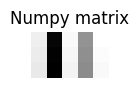


==================== TensorFlow matrix | tensor_info ====================
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape: (3, 5) | nDims: 2 | dtype: <dtype: 'int64'>
TensorFlow matrix[0]: [ 5 78  2 34  0]


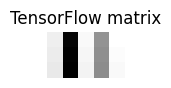


==================== PyTorch matrix | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([3, 5]) | nDims: 2 | dtype: torch.int64
PyTorch matrix[0]: tensor([ 5, 78,  2, 34,  0])


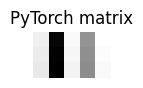

In [22]:
x = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])
tensor_toolbox.tensor_info(x, "Numpy matrix")
x = tf.constant(x)
tensor_toolbox.tensor_info(x, "TensorFlow matrix")
x = torch.tensor(np.array(x))
tensor_toolbox.tensor_info(x, "PyTorch matrix")

### Rank-3 and higher-rank tensors

In [23]:
x = np.array([[[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]]])
tensor_toolbox.tensor_info(x, "Numpy tensor")
x = tf.constant(x)
tensor_toolbox.tensor_info(x, "TensorFlow tensor")
x = torch.tensor(np.array(x))
tensor_toolbox.tensor_info(x, "PyTorch tensor")
# Can't visualize this one, but trust me it's a 3D tensor.

==================== Numpy tensor | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (3, 3, 5) | nDims: 3 | dtype: int64

==================== TensorFlow tensor | tensor_info ====================
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape: (3, 3, 5) | nDims: 3 | dtype: <dtype: 'int64'>

==================== PyTorch tensor | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([3, 3, 5]) | nDims: 3 | dtype: torch.int64



### Key attributes

In [24]:
# These are included in tensor_toolbox.tensor_info()!
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [25]:
train_images.ndim

3

In [26]:
train_images.shape

(60000, 28, 28)

In [27]:
train_images.dtype

dtype('uint8')

==================== train_images | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (60000, 28, 28) | nDims: 3 | dtype: uint8


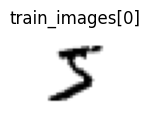

In [28]:
tensor_toolbox.tensor_info(train_images, "train_images")

**Listing 2.8: Displaying the fourth digit**

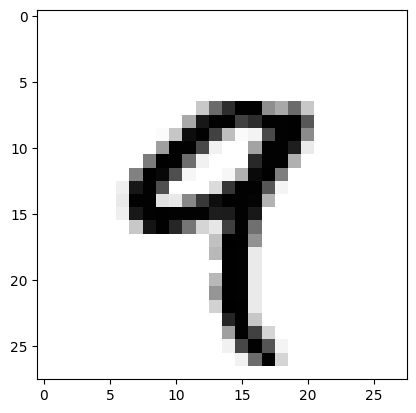

In [29]:
# tensor_toolbox.py is your friend
import matplotlib.pyplot as plt
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

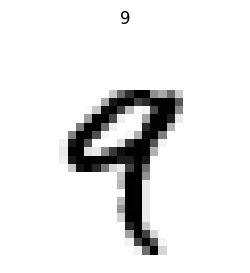

In [30]:
tensor_toolbox.draw_image(train_images[4], train_labels[4], size=3)

### Manipulating tensors in NumPy

==================== my_slice | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (90, 28, 28) | nDims: 3 | dtype: uint8


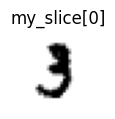

In [31]:
# They are all the same!
my_slice = train_images[10:100]
my_slice = train_images[10:100, :, :]
my_slice = train_images[10:100, 0:28, 0:28]
tensor_toolbox.tensor_info(my_slice, "my_slice")

==================== my_slice | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (60000, 14, 14) | nDims: 3 | dtype: uint8


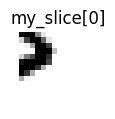


==================== whole picture | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (28, 28) | nDims: 2 | dtype: uint8
whole picture[0]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
... (showing only the first 20 elements)


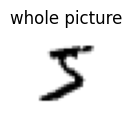

In [32]:
my_slice = train_images[:, 14:, 14:]
tensor_toolbox.tensor_info(my_slice, "my_slice")
tensor_toolbox.tensor_info(train_images[0], "whole picture")
# You can see that the first 14 pixels are the bottom right corner.

==================== my_slice | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (60000, 14, 14) | nDims: 3 | dtype: uint8


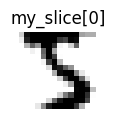

In [33]:
my_slice = train_images[:, 7:-7, 7:-7]
tensor_toolbox.tensor_info(my_slice, "my_slice")
# This 'cuts' the margins

### The notion of data batches

==================== batch | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (128, 28, 28) | nDims: 3 | dtype: uint8


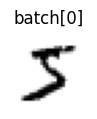


==================== batch | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (128, 28, 28) | nDims: 3 | dtype: uint8


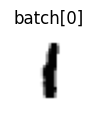


==================== batch | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (128, 28, 28) | nDims: 3 | dtype: uint8


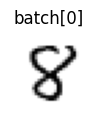

In [34]:
batch = train_images[:128] #First batch
tensor_toolbox.tensor_info(batch, "batch")
batch = train_images[128:256] # Second batch
tensor_toolbox.tensor_info(batch, "batch")
n = 42
batch = train_images[128 * n:128 * (n + 1)] # n-th batch
tensor_toolbox.tensor_info(batch, "batch")

==================== batch | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([128, 1, 28, 28]) | nDims: 4 | dtype: torch.float32


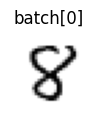

In [35]:
# Using PyTorch DataLoader, batches are automatically implemented.
# Retrieve batch n from train_dataloader in a wildly inefficient way:
for i, (X, y) in enumerate(train_dataloader):
    if i == n:
        batch = X
        break
tensor_toolbox.tensor_info(batch, "batch")

## The gears of neural networks: tensor operations

### Element-wise operations

In [36]:
# These are wild!
def naive_relu(x):
    assert len(x.shape) == 2
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x

In [37]:
def naive_add(x, y):
    assert len(x.shape) == 2
    assert x.shape == y.shape
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x

In [38]:
def np_version (x, y, iters):
    for _ in range(iters):
        z = x + y
        z = np.maximum(z, 0.)

def tf_version (x, y, iters):
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)
    for _ in range(iters):
        z = x + y
        z = tf.maximum(z, tf.constant(0., dtype=z.dtype))

def torch_version (x, y, iters):
    x = torch.tensor(x)
    y = torch.tensor(y)
    for _ in range(iters):
        z = x + y
        z = torch.max(z, torch.tensor(0.))


In [39]:
def naive_version (x, y, iters):
    for _ in range(5000):
        z = naive_add(x, y)
        z = naive_relu(z)

In [40]:
# Fun Function:
x = np.random.random((20, 100))
y = np.random.random((20, 100))
tensor_toolbox.function_race([np_version, tf_version, torch_version, naive_version], [x, y, 5000]) 
# I wouldn't give a lot of value to this results but it's fun.

Trying np_version
np_version succeeded
Took: 0.01100 s

Trying tf_version
tf_version succeeded
Took: 0.23346 s

Trying torch_version
torch_version succeeded
Took: 0.03248 s

Trying naive_version
naive_version succeeded
Took: 4.17032 s



### Broadcasting

==================== X | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (32, 10) | nDims: 2 | dtype: float64
X[0]: [0.3250931  0.61506914 0.38978521 0.74487887 0.94132154 0.56439668
 0.00359465 0.60419574 0.3071076  0.65458413]
... (showing only the first 20 elements)


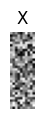


==================== y | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (10,) | nDims: 1 | dtype: float64
Content: [0.53939921 0.20033564 0.13357748 0.06324783 0.97126593 0.00783796
 0.81031836 0.64067816 0.3447947  0.56354798]



In [41]:
import numpy as np
X = np.random.random((32, 10))
y = np.random.random((10,))

tensor_toolbox.tensor_info(X, "X")
tensor_toolbox.tensor_info(y, "y")

In [42]:
y_expanded = np.expand_dims(y, axis=0)
tensor_toolbox.tensor_info(y_expanded, "y")

==================== y | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (1, 10) | nDims: 2 | dtype: float64
Content: [[0.53939921 0.20033564 0.13357748 0.06324783 0.97126593 0.00783796
  0.81031836 0.64067816 0.3447947  0.56354798]]



==================== Y | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (32, 10) | nDims: 2 | dtype: float64
Y[0]: [0.53939921 0.20033564 0.13357748 0.06324783 0.97126593 0.00783796
 0.81031836 0.64067816 0.3447947  0.56354798]
... (showing only the first 20 elements)


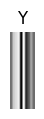

In [43]:
Y = np.concatenate([y_expanded] * 32, axis=0)
tensor_toolbox.tensor_info(Y, "Y")

In [44]:
def naive_add_matrix_and_vector(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

In [45]:
import numpy as np
x = np.random.random((64, 3, 32, 10))
y = np.random.random((32, 10))
z = np.maximum(x, y)
tensor_toolbox.tensor_info(z, "z")

==================== z | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (64, 3, 32, 10) | nDims: 4 | dtype: float64



### Tensor product

In [46]:
x = np.random.random((32,))
y = np.random.random((32,))
z = np.dot(x, y)

In [47]:
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    return z

In [48]:
def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    return z

In [49]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z

In [50]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    assert x.shape[1] == y.shape[0]
    z = np.zeros((x.shape[0], y.shape[1]))
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z

### Tensor reshaping

==================== Before reshape | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (60000, 28, 28) | nDims: 3 | dtype: uint8


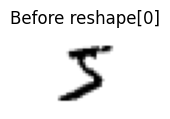


==================== After reshape | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (60000, 784) | nDims: 2 | dtype: uint8
After reshape[0]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
... (showing only the first 20 elements)



In [51]:
tensor_toolbox.tensor_info(train_images, "Before reshape")
train_images_reshaped = train_images.reshape((60000, 28 * 28))
tensor_toolbox.tensor_info(train_images_reshaped, "After reshape", image=False) 
# The previous one only displays the first image. I could do the same but it doesn't make a lot of sense
# as the images are now mono-dimensional. This image would be 60000*784, each digit being one row.

In [52]:
x = np.array([[0., 1.],
             [2., 3.],
             [4., 5.]])
x.shape

(3, 2)

In [53]:
x = x.reshape((6, 1))
x

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

In [54]:
x = np.zeros((300, 20))
x = np.transpose(x)
x.shape

(20, 300)

## The engine of neural networks: gradient-based optimization

#### The gradient tape in TensorFlow

In [79]:
import tensorflow as tf
# In TensorFlow, we use Gradient Tape to compute gradients.
x = tf.Variable(0.) # Variable to compute the gradient
with tf.GradientTape() as tape: # Gradient tape context
    # Every operation inside the context is recorded on the tape
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)
tensor_toolbox.tensor_info(grad_of_y_wrt_x, "Gradient of y wrt x")
# Honestly, this is unbelievably cool.

==================== x | tensor_info ====================
Type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
Shape: () | dtype: <dtype: 'float32'>
Content: 0.0

==================== Gradient of y wrt x | tensor_info ====================
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape: () | nDims: 0 | dtype: <dtype: 'float32'>
Content: 2.0



In [89]:
import torch
# In PyTorch, we use the requires_grad attribute to compute gradients.
x = torch.tensor(0., requires_grad=True) # Variable to compute the gradient
y = 2 * x + 3
y.backward() # Compute the gradient of y wrt x
tensor_toolbox.tensor_info(x, "x")
# From a math point of view it is just incredible that this
# is even possible. Sooooo beautiful.

==================== x | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([]) | nDims: 0 | dtype: torch.float32
Content: 0.0
-- Gradient:
Type: <class 'torch.Tensor'>
Shape: torch.Size([]) | nDims: 0 | dtype: torch.float32
Content: 2.0




In [57]:
x = tf.Variable(tf.random.uniform((2, 2))) # 2x2 matrix
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)
tensor_toolbox.tensor_info(grad_of_y_wrt_x, "Gradient of y wrt x", image=False)

==================== Gradient of y wrt x | tensor_info ====================
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape: (2, 2) | nDims: 2 | dtype: <dtype: 'float32'>
Gradient of y wrt x[0]: [2. 2.]



In [90]:
# In PyTorch:
x = torch.rand((2, 2), requires_grad=True) # 2x2 matrix
y = 2 * x + 3
y.backward(torch.ones_like(y)) # Compute the gradient of y wrt x
# The argument ones_like(y) is a tensor of ones with the same shape as y.
# It is necessary because y is not a scalar, so we need to provide the gradient 
# of the output with respect to itself.
grad_of_y_wrt_x = x.grad
tensor_toolbox.tensor_info(grad_of_y_wrt_x, "Gradient of y wrt x", image=False)


==================== Gradient of y wrt x | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([2, 2]) | nDims: 2 | dtype: torch.float32
Gradient of y wrt x[0]: tensor([2., 2.])



In [59]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))
with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b

grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])
tensor_toolbox.tensor_info(grad_of_y_wrt_W_and_b[0], "Gradient of y wrt W", image=False)
tensor_toolbox.tensor_info(grad_of_y_wrt_W_and_b[1], "Gradient of y wrt b", image=False)

==================== Gradient of y wrt W | tensor_info ====================
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape: (2, 2) | nDims: 2 | dtype: <dtype: 'float32'>
Gradient of y wrt W[0]: [0.54304206 0.54304206]

==================== Gradient of y wrt b | tensor_info ====================
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape: (2,) | nDims: 1 | dtype: <dtype: 'float32'>
Content: [2. 2.]



In [93]:
W = torch.rand((2, 2), requires_grad=True)
b = torch.zeros((2,), requires_grad=True)
x = torch.rand((2, 2))
y = torch.matmul(x, W) + b
y.backward(torch.ones_like(y))
grad_of_y_wrt_W = W.grad
grad_of_y_wrt_b = b.grad
tensor_toolbox.tensor_info(W, "W", image=False)
tensor_toolbox.tensor_info(b, "b", image=False)

==================== W | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([2, 2]) | nDims: 2 | dtype: torch.float32
W[0]: tensor([0.6129, 0.3994], grad_fn=<SliceBackward0>)
-- Gradient:
Type: <class 'torch.Tensor'>
Shape: torch.Size([2, 2]) | nDims: 2 | dtype: torch.float32
gradient[0]: tensor([0.9144, 0.9144])


==================== b | tensor_info ====================
Type: <class 'torch.Tensor'>
Shape: torch.Size([2]) | nDims: 1 | dtype: torch.float32
Content: tensor([0., 0.], grad_fn=<SliceBackward0>)
-- Gradient:
Type: <class 'torch.Tensor'>
Shape: torch.Size([2]) | nDims: 1 | dtype: torch.float32
Content: tensor([2., 2.])




## Looking back at our first example

In [61]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [62]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [63]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [64]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)
# Honestly, it's impressive how Keras manages to obtain the data,
# build a neural network and train it in just a few lines of code.
# However, it's probably good to look a bit further to get a better understanding.

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.2584 - accuracy: 0.9242
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1041 - accuracy: 0.9685
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0676 - accuracy: 0.9797
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0497 - accuracy: 0.9849
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0376 - accuracy: 0.9886


### Reimplementing our first example from scratch in TensorFlow

#### A simple Dense class

In [65]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

#### A simple Sequential class

In [66]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [67]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

#### A batch generator

In [68]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

### Running one training step

In [69]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [70]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)

In [71]:
from tensorflow.keras import optimizers

optimizer = optimizers.legacy.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

### The full training loop

In [72]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

In [73]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 6.21
loss at batch 100: 2.25
loss at batch 200: 2.24
loss at batch 300: 2.12
loss at batch 400: 2.25
Epoch 1
loss at batch 0: 1.93
loss at batch 100: 1.89
loss at batch 200: 1.87
loss at batch 300: 1.74
loss at batch 400: 1.85
Epoch 2
loss at batch 0: 1.60
loss at batch 100: 1.59
loss at batch 200: 1.54
loss at batch 300: 1.44
loss at batch 400: 1.52
Epoch 3
loss at batch 0: 1.34
loss at batch 100: 1.36
loss at batch 200: 1.27
loss at batch 300: 1.22
loss at batch 400: 1.28
Epoch 4
loss at batch 0: 1.14
loss at batch 100: 1.17
loss at batch 200: 1.07
loss at batch 300: 1.06
loss at batch 400: 1.11
Epoch 5
loss at batch 0: 0.99
loss at batch 100: 1.03
loss at batch 200: 0.92
loss at batch 300: 0.94
loss at batch 400: 0.99
Epoch 6
loss at batch 0: 0.88
loss at batch 100: 0.92
loss at batch 200: 0.82
loss at batch 300: 0.84
loss at batch 400: 0.90
Epoch 7
loss at batch 0: 0.79
loss at batch 100: 0.84
loss at batch 200: 0.73
loss at batch 300: 0.77
loss at batch 40

### Evaluating the model

In [74]:
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

accuracy: 0.82


In [75]:
# Big TODO: PyTorch implementation done before is already quite similar.
# However, I want to go line by line over the tf implementation.
# Also also, I did a numpy version that worked kind of ok-ish in MNIST digits.
# I could try to find it and add it here, with algebraic notation.